In [82]:
#import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, ReLU, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from ultralytics import YOLO
from keras.callbacks import ModelCheckpoint

from PIL import Image

from tensorflow.keras.applications import VGG19 as vgg

from matplotlib.pyplot import imshow


In [21]:
#read the data
#The data is read from the directory and each batch can be thought of as a set of labels and datapoints
#Might need to change the directory depending on where

#Seed 50 is decent performing
train = keras.utils.image_dataset_from_directory(
    directory='../../data/Faces',
    labels='inferred',
    label_mode='categorical',
    batch_size=140,
    image_size=(1000, 1000),
    validation_split = 0.2,
    subset = 'training',
    seed = 50
    )

validation = keras.utils.image_dataset_from_directory(
    directory='../../data/Faces',
    labels='inferred',
    label_mode='categorical',
    batch_size=140,
    image_size=(1000, 1000),
    validation_split = 0.2,
    subset = 'validation',
    seed = 50
    )

Found 140 files belonging to 6 classes.
Using 112 files for training.
Found 140 files belonging to 6 classes.
Using 28 files for validation.


In [22]:
train_processed = train.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))

validation_processed = validation.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))

In [62]:

train_processed_numpy = train.as_numpy_iterator()
validation_processed_numpy = validation.as_numpy_iterator()

X_train, y_train = train_processed_numpy.next()
X_val, y_val = validation_processed_numpy.next()

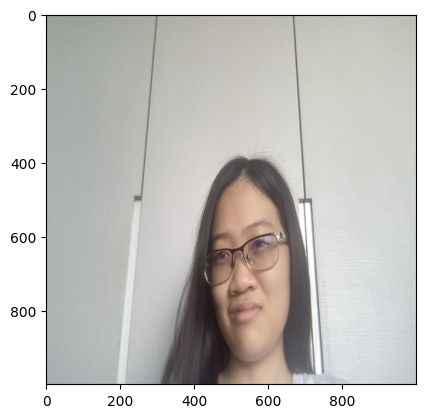

In [64]:
imshow(X_train[:,:,:,[0,1,2]][15]/255)

In [71]:
#convert the images to cropped faces
face_classifier = YOLO("../../app/src/face_detection/model/yolov8n-face.pt")

X_cropped_train = []
y_train_cropped = []

for i in range(112):
    face = X_train[i]
    faces = face_classifier.predict(face)
    boxes = faces[0].boxes.xyxy.tolist()
    if boxes:
        
        #extract the face based on the output from the YOLOv8 model        
        left, bottom, right, top = boxes[0]
        cropped_face = face[int(bottom):int(top), int(left):int(right)]
        #resize cropped face to a std shape, 100x100 for now but can adjust this
        pil_face = Image.fromarray(np.uint8(cropped_face))
        pil_face = pil_face.resize((48, 48))
        numpy_cropped_face = np.array(pil_face)
        #append this to the new list containing all cropped faces
        X_cropped_train.append(numpy_cropped_face)
        y_train_cropped.append(y_train[i])

X_val_cropped = []
y_val_cropped = []

for i in range(28):
    face = X_val[i]
    faces = face_classifier.predict(face)
    boxes = faces[0].boxes.xyxy.tolist()
    if boxes:
        
        #extract the face based on the output from the YOLOv8 model        
        left, bottom, right, top = boxes[0]
        cropped_face = face[int(bottom):int(top), int(left):int(right)]
        #resize cropped face to a std shape, 100x100 for now but can adjust this
        pil_face = Image.fromarray(np.uint8(cropped_face))
        pil_face = pil_face.resize((48, 48))
        numpy_cropped_face = np.array(pil_face)
        #append this to the new list containing all cropped faces
        X_val_cropped.append(numpy_cropped_face)
        y_val_cropped.append(y_val[i])



0: 640x640 1 face, 103.6ms
Speed: 0.0ms preprocess, 103.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 79.9ms
Speed: 15.7ms preprocess, 79.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 71.6ms
Speed: 7.0ms preprocess, 71.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 79.1ms
Speed: 14.6ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 80.2ms
Speed: 7.0ms preprocess, 80.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 75.5ms
Speed: 8.0ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 79.1ms
Speed: 7.3ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 

In [40]:
X_train.shape

(112, 1000, 1000, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


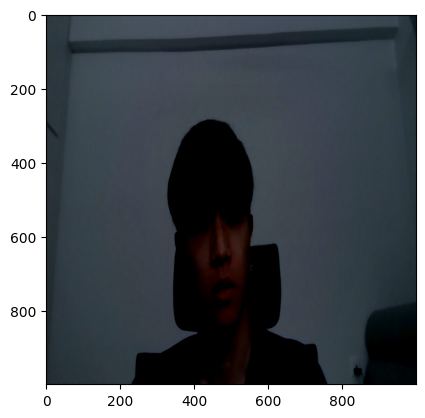

In [77]:
X_cropped_train = np.array(X_cropped_train)
print(X_cropped_train.shape)
y_train_cropped = np.array(y_train_cropped)

X_cropped_val = np.array(X_val_cropped)
print(X_cropped_val.shape)
y_val_cropped = np.array(y_val_cropped)

(110, 48, 48, 3)
(28, 48, 48, 3)


In [85]:
#flatten the output
inputs = Input(shape=(48, 48, 3))

#set inference mode to be false, flatten the output and add dense layers before making the final prediction
vgg_output = keras.applications.VGG19(input_tensor=inputs,                                      
    include_top=False,
    weights="imagenet",

    input_shape=(48, 48, 3),
    pooling=None,


)
for layer in vgg_output.layers:
    layer.trainable = False
flatten = Flatten()(vgg_output.output)
dense1 = Dense(256, activation = 'relu', name = 'first_dense_layer')(flatten)
dropout1 = Dropout(0.25)(dense1)
batch_norm1 = BatchNormalization(name = 'batch_norm1')(dropout1)
dense2 = Dense(256, activation = 'relu', name = 'second_dense_layer')(batch_norm1)
dropout2 = Dropout(0.25)(dense2)
batch_norm1 = BatchNormalization(name = 'batch_norm2')(dropout2)
output = Dense(6, activation = 'softmax', name = 'output')(batch_norm1)
final_model = Model(inputs, output)


# In[ ]:



final_model.compile(optimizer = 'adam', loss = CategoricalCrossentropy(), metrics = ['accuracy'])
#save the model every epoch
checkpoint = ModelCheckpoint(filepath = 'vggemotion.keras')



In [86]:
final_model.fit(x=X_cropped_train,y= y_train_cropped, validation_data = (X_cropped_val, y_val_cropped), epochs=40)


# In[ ]:


final_model.save('vggemotion.keras')

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.1524 - loss: 2.5814 - val_accuracy: 0.1071 - val_loss: 4.5238
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.2810 - loss: 1.8951 - val_accuracy: 0.1071 - val_loss: 3.2313
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.4282 - loss: 1.4585 - val_accuracy: 0.2500 - val_loss: 2.6135
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.4693 - loss: 1.4268 - val_accuracy: 0.2500 - val_loss: 2.3953
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.5957 - loss: 1.1904 - val_accuracy: 0.2500 - val_loss: 2.1589
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.5983 - loss: 1.0572 - val_accuracy: 0.2500 - val_loss: 2.0524
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.7347 - loss: 0.8238 - val_accuracy: 0.2143 - val_loss: 2.0461
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.6769 - loss: 0.8892 - val_accuracy: 0.2500 - val_loss:

# Try the above but with dataset augmentations



In [95]:
train = keras.utils.image_dataset_from_directory(
    directory='../../data/Processed/Train',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(1000, 1000),


    )

validation = keras.utils.image_dataset_from_directory(
    directory='../../data/Processed/Validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(1000, 1000),


    )

Found 804 files belonging to 6 classes.
Found 219 files belonging to 6 classes.


In [96]:
train_processed = train.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))

validation_processed = validation.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))

In [97]:
train_processed_numpy = train_processed.as_numpy_iterator()
validation_processed_numpy = validation_processed.as_numpy_iterator()


(32, 1000, 1000, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



0: 640x640 1 face, 116.4ms
Speed: 0.0ms preprocess, 116.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 86.0ms
Speed: 0.0ms preprocess, 86.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 83.8ms
Speed: 2.6ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 89.9ms
Speed: 14.1ms preprocess, 89.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 88.0ms
Speed: 3.2ms preprocess, 88.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 82.8ms
Speed: 6.4ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 67.1ms
Speed: 16.2ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 85.4ms
Speed: 2.6ms preprocess, 85.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 

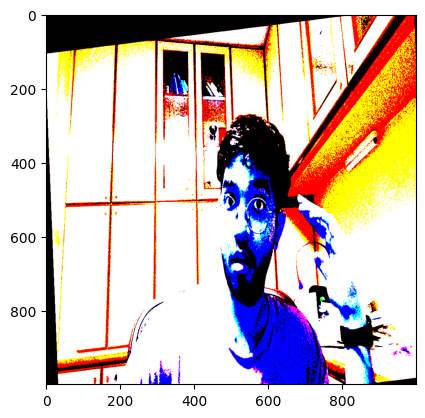

In [98]:
#convert the images to cropped faces
face_classifier = YOLO("../../app/src/face_detection/model/yolov8n-face.pt")

X_train_cropped = []
y_train = []

for i in range(804):
    face, y_train_i = train_processed_numpy.next()
    face = face.reshape((face.shape[1], face.shape[2], face.shape[3]))
    if i == 0:
        imshow(face)
    faces = face_classifier.predict(face)
    boxes = faces[0].boxes.xyxy.tolist()
    if boxes:
        
        #extract the face based on the output from the YOLOv8 model        
        left, bottom, right, top = boxes[0]
        cropped_face = face[int(bottom):int(top), int(left):int(right)]
        #resize cropped face to a std shape, 100x100 for now but can adjust this
        pil_face = Image.fromarray(np.uint8(cropped_face))
        pil_face = pil_face.resize((48, 48))
        numpy_cropped_face = np.array(pil_face)
        #append this to the new list containing all cropped faces
        X_train_cropped.append(numpy_cropped_face)
        y_train.append(y_train_i)

X_val_cropped = []
y_val = []

for i in range(219):
    face, y_val_i = validation_processed_numpy.next()
    face = face.reshape((face.shape[1], face.shape[2], face.shape[3]))
    faces = face_classifier.predict(face)
    
    boxes = faces[0].boxes.xyxy.tolist()
    if boxes:
        
        #extract the face based on the output from the YOLOv8 model        
        left, bottom, right, top = boxes[0]
        cropped_face = face[int(bottom):int(top), int(left):int(right)]
        #resize cropped face to a std shape, 100x100 for now but can adjust this
        pil_face = Image.fromarray(np.uint8(cropped_face))
        pil_face = pil_face.resize((48, 48))
        numpy_cropped_face = np.array(pil_face)
        #append this to the new list containing all cropped faces
        X_val_cropped.append(numpy_cropped_face)
        y_val.append(y_val_i)



In [109]:
#convert data to numpy input
X_train_cropped = np.array(X_train_cropped)
print(X_train_cropped.shape)
y_train = np.array(y_train)

X_cropped_val = np.array(X_val_cropped)
print(X_cropped_val.shape)
y_val = np.array(y_val)

(692, 48, 48, 3)
(195, 48, 48, 3)


In [114]:
y_train = y_train.reshape(692,6)
y_val = y_val.reshape(195,6)

In [103]:
#flatten the output
inputs = Input(shape=(48, 48, 3))

#set inference mode to be false, flatten the output and add dense layers before making the final prediction
vgg_output = keras.applications.VGG19(input_tensor=inputs,                                      
    include_top=False,
    weights="imagenet",

    input_shape=(48, 48, 3),
    pooling=None,


)
for layer in vgg_output.layers:
    layer.trainable = False
flatten = Flatten()(vgg_output.output)
dense1 = Dense(256, activation = 'relu', name = 'first_dense_layer')(flatten)
dropout1 = Dropout(0.25)(dense1)
batch_norm1 = BatchNormalization(name = 'batch_norm1')(dropout1)
dense2 = Dense(256, activation = 'relu', name = 'second_dense_layer')(batch_norm1)
dropout2 = Dropout(0.25)(dense2)
batch_norm1 = BatchNormalization(name = 'batch_norm2')(dropout2)
output = Dense(6, activation = 'softmax', name = 'output')(batch_norm1)
final_model = Model(inputs, output)


# In[ ]:



final_model.compile(optimizer = 'adam', loss = CategoricalCrossentropy(), metrics = ['accuracy'])
#save the model every epoch
checkpoint = ModelCheckpoint(filepath = 'vggemotion.keras')



In [115]:
final_model.fit(x=X_cropped_train,y= y_train_cropped, validation_data = (X_cropped_val, y_val), epochs=40)


# In[ ]:


final_model.save('vggemotion.keras')

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step - accuracy: 0.5406 - loss: 1.2813 - val_accuracy: 0.2308 - val_loss: 4.3961
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.5807 - loss: 1.3000 - val_accuracy: 0.2564 - val_loss: 4.3154
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.6020 - loss: 1.1221 - val_accuracy: 0.2513 - val_loss: 4.3784
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 589ms/step - accuracy: 0.6046 - loss: 1.0916 - val_accuracy: 0.2564 - val_loss: 4.2673
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 839ms/step - accuracy: 0.7654 - loss: 0.7956 - val_accuracy: 0.2462 - val_loss: 4.1791
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 905ms/step - accuracy: 0.7055 - loss: 0.8457 - val_accuracy: 0.2462 - val_loss: 4.2149
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 864ms/step - accuracy: 0.7940 - loss: 0.6537 - val_accuracy: 0.2462 - val_loss: 4.1615
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 801ms/step - accuracy: 0.6998 - loss: 0.7829 - val_accuracy: 0.2513 - val_loss: